<a href="https://colab.research.google.com/github/ferdzo/vesselDetection/blob/master/vesselDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!cd /content/
!kaggle datasets download -d siddharthkumarsah/ships-in-aerial-images
!unzip ships-in-aerial-images.zip

KeyboardInterrupt: ignored

# **Imports**

In [2]:
%%capture
!pip install super-gradients

In [3]:
import os
import requests
import torch
from PIL import Image

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val
)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)
from super_gradients.training.utils.distributed_training_utils import setup_device



[2023-06-15 23:09:12] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-06-15 23:09:26] INFO - utils.py - NumExpr defaulting to 2 threads.
[2023-06-15 23:09:26] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-06-15 23:09:26] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-06-15 23:09:26] WARNING - export.py - Failed to import pytorch_quantization
[2023-06-15 23:09:26] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


Super gradients YOLO import


# Config

In [4]:
class config:
    CHECKPOINT_DIR = 'checkpoints'
    EXPERIMENT_NAME = 'vesselFinder'
    DATA_DIR = '/content/ships-aerial-images'
    TRAIN_IMAGES_DIR = 'train/images'
    TRAIN_LABELS_DIR = 'train/labels'

    VAL_IMAGES_DIR = 'valid/images'
    VAL_LABELS_DIR = 'valid/labels'

    TEST_IMAGES_DIR = 'test/images'
    TEST_LABELS_DIR = 'test/labels'

    CLASSES = ['ship']
    NUM_CLASSES = len(CLASSES)

    DATALOADER_PARAMS={
    'batch_size':16,
    'num_workers':2
    }

    MODEL_NAME = 'yolo_nas_l' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco'



In [5]:
# setup_device(device = 'cpu')
trainer = Trainer(experiment_name = config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

In [6]:
train_data= coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)
test_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

Caching annotations: 100%|██████████| 9697/9697 [00:03<00:00, 2599.13it/s]
[2023-06-15 23:09:45] WARNING - detection_dataset.py - Found 497 invalid bbox that were ignored. For more information, please set `show_all_warnings=True`.
Caching annotations: 100%|██████████| 2165/2165 [00:01<00:00, 1752.17it/s]
[2023-06-15 23:09:46] WARNING - detection_dataset.py - Found 113 invalid bbox that were ignored. For more information, please set `show_all_warnings=True`.
Caching annotations: 100%|██████████| 1573/1573 [00:00<00:00, 2941.03it/s]
[2023-06-15 23:09:48] WARNING - detection_dataset.py - Found 68 invalid bbox that were ignored. For more information, please set `show_all_warnings=True`.


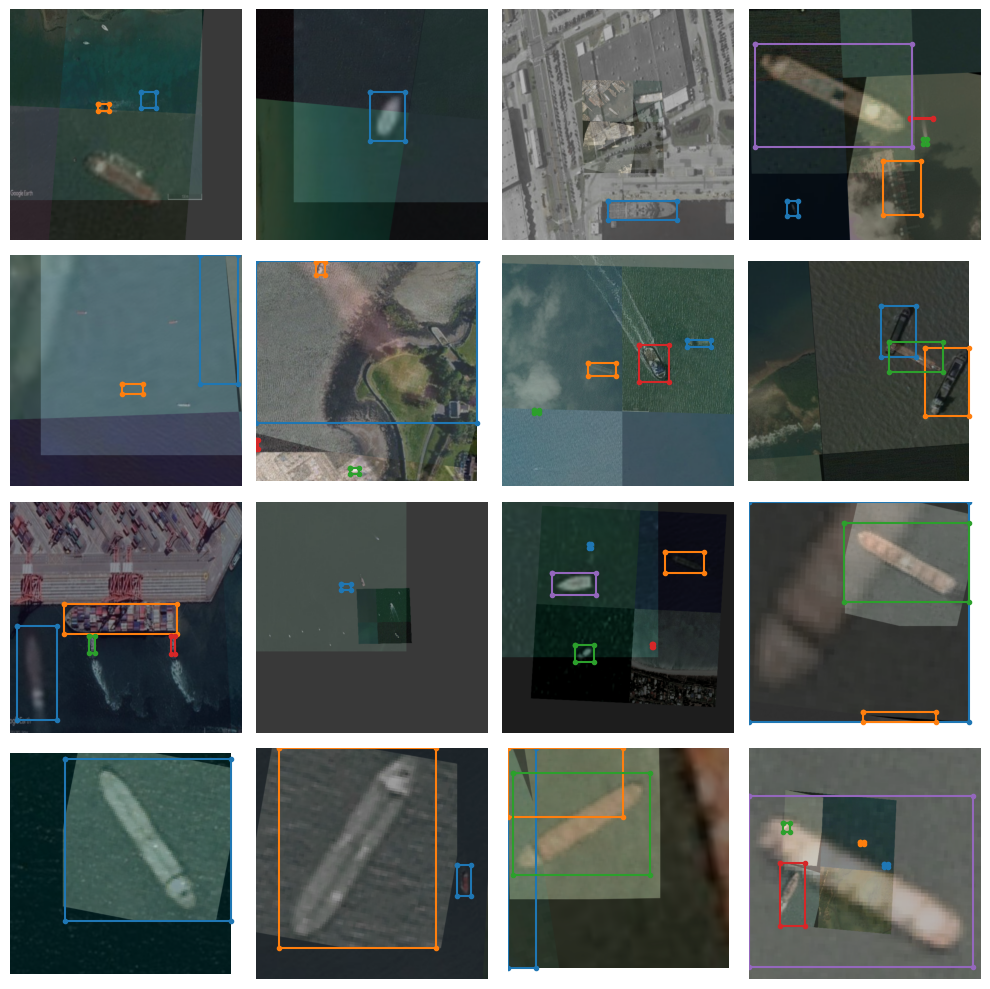

In [7]:
train_data.dataset.plot()

# Model

In [8]:
model = models.get(config.MODEL_NAME,num_classes=config.NUM_CLASSES,pretrained_weights=config.PRETRAINED_WEIGHTS)

[2023-06-15 23:09:57] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:04<00:00, 62.8MB/s]


# Training parameters

In [9]:
train_params = {
    # ENABLING SILENT MODE
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
        "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# Training

In [ ]:
trainer.train(model=model,training_params=train_params,train_loader=train_data,valid_loader=val_data)

The console stream is now moved to checkpoints/vesselFinder/console_Jun15_23_12_41.txt


[2023-06-15 23:12:41] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-06-15 23:12:44] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 9245       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         577        (len(train_loader))
    - Gradient updates per epoch:   577        (len(train_loader) / batch_accumulate)

[2023-06-15 23:12:44] INFO - sg_trainer.py - Started training for 10 epochs (0/9)

Train epoch 0:  25%|██▌       | 147/577 [03:13<09:19,  1.30s/it, PPYoloELoss/loss=3.52, PPYoloELoss/loss_cls

In [ ]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, 'average_model.pth'))

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
               top_k_predictions=300,
               num_cls=config.NUM_CLASSES,
               normalize_targets=True,
               post_prediction_callback=PPYoloEPostPredictionCallback(
                  score_threshold=0.01,
                  nms_top_k=1000,
                  max_predictions=300,
                  nms_threshold=0.7)
               ))